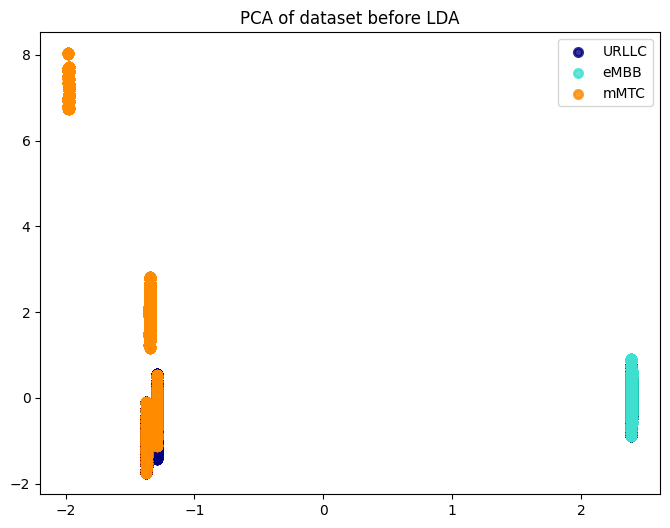

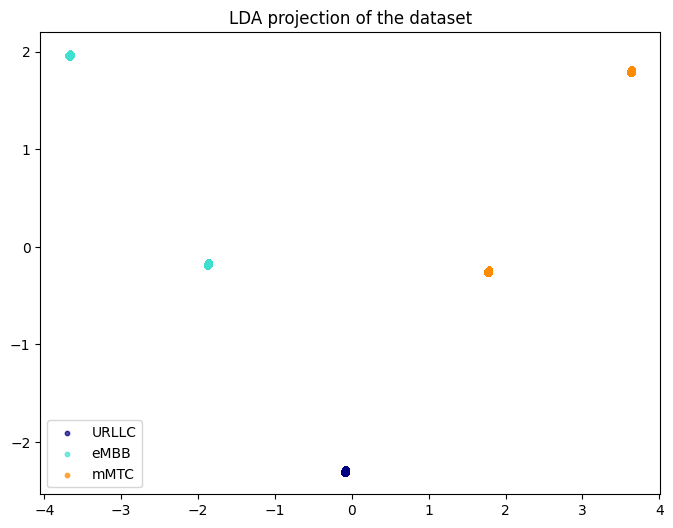

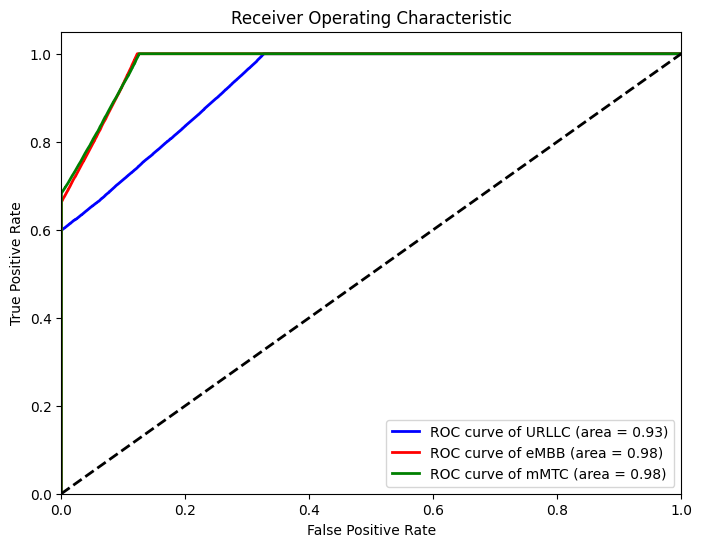

Accuracy: 0.820206824641842
Confusion Matrix:
       URLLC   eMBB   mMTC
URLLC  37521  12547  12628
eMBB       0  37760      0
mMTC       0      0  39566
Classification Report:
              precision    recall  f1-score   support

       URLLC       1.00      0.60      0.75     62696
        eMBB       0.75      1.00      0.86     37760
        mMTC       0.76      1.00      0.86     39566

    accuracy                           0.82    140022
   macro avg       0.84      0.87      0.82    140022
weighted avg       0.86      0.82      0.81    140022



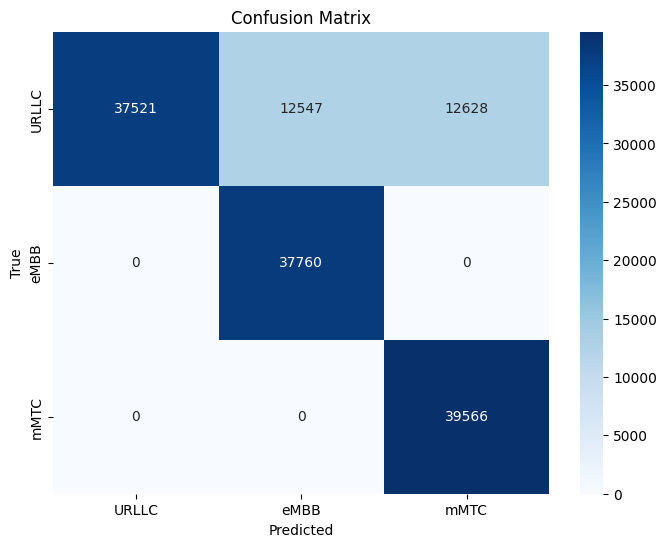

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.metrics import roc_curve, auc, accuracy_score, confusion_matrix, classification_report, roc_auc_score
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

# Load the processed dataset
df = pd.read_csv(r"C:\Users\anifa\Desktop\GITB\EECE5644-Intro_to_ML\Project\Dataset\processed_data_without_packet_loss_delay\processed_data_without_packet_loss_delay.csv")

# Drop any columns that are completely empty or that are just unnamed indices
df.drop(columns=[col for col in df.columns if 'Unnamed' in col or df[col].isnull().all()], inplace=True)

# Separate features and target
X = df.drop(['Slice Type (Output)_URLLC', 'Slice Type (Output)_eMBB', 'Slice Type (Output)_mMTC'], axis=1)
y = df[['Slice Type (Output)_URLLC', 'Slice Type (Output)_eMBB', 'Slice Type (Output)_mMTC']].idxmax(axis=1)

# Map the combined targets to class names
class_mapping = {'Slice Type (Output)_URLLC': 'URLLC', 'Slice Type (Output)_eMBB': 'eMBB', 'Slice Type (Output)_mMTC': 'mMTC'}
y = y.map(class_mapping)

# Encode the class names to integers
y_encoded = y.astype('category').cat.codes

# Standardize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Visualizing the dataset before LDA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)
plt.figure(figsize=(8, 6))
colors = ['navy', 'turquoise', 'darkorange']
lw = 2
labels = list(class_mapping.values())
for color, i, label in zip(colors, range(len(labels)), labels):
    plt.scatter(X_pca[y_encoded == i, 0], X_pca[y_encoded == i, 1], color=color, alpha=.8, lw=lw,
                label=label)
plt.legend(loc='best', shadow=False, scatterpoints=1)
plt.title('PCA of dataset before LDA')
plt.show()

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_encoded, test_size=0.3, random_state=42)

# Initialize and train the LDA model
lda = LinearDiscriminantAnalysis(n_components=2)
lda.fit(X_train, y_train)
X_lda = lda.transform(X_scaled)  # transform the whole dataset for visualization

# Visualizing the dataset after LDA
plt.figure(figsize=(8, 6))
for color, i, label in zip(colors, range(len(labels)), labels):
    plt.scatter(X_lda[y_encoded == i, 0], X_lda[y_encoded == i, 1], alpha=0.7, s=10, color=color,
                label=label)
plt.legend(loc='best', shadow=False, scatterpoints=1)
plt.title('LDA projection of the dataset')
plt.show()

# Predict on the test set
y_pred = lda.predict(X_test)
y_prob = lda.predict_proba(X_test)  # Get probabilities for ROC calculation

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)

# Generate the confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)

# Create a classification report
report = classification_report(y_test, y_pred, target_names=labels)

# Compute ROC AUC for each class
roc_auc = roc_auc_score(y_test, y_prob, multi_class="ovr", average=None)

# Plot ROC curves
plt.figure(figsize=(8, 6))
colors = ['blue', 'red', 'green']
for i, color in enumerate(colors):
    fpr, tpr, _ = roc_curve(y_test == i, y_prob[:, i])
    plt.plot(fpr, tpr, color=color, lw=2,
             label='ROC curve of {0} (area = {1:0.2f})'.format(labels[i], roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

# Display the accuracy, confusion matrix, and classification report
print('Accuracy:', accuracy)
print('Confusion Matrix:')
print(pd.DataFrame(conf_matrix, index=labels, columns=labels))
print('Classification Report:')
print(report)


# Plotting the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap='Blues', xticklabels=list(class_mapping.values()), yticklabels=list(class_mapping.values()))
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()